In [12]:
#pip install yfinance
!pip install statsmodels arch

  Obtaining dependency information for arch from https://files.pythonhosted.org/packages/37/08/acd7fbc1e15b4701b5be3acd6fd575865a274885ea6bc72ec7af909cc7e5/arch-7.0.0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/924.9 kB ? eta -:--:--
   --- ------------------------------------ 92.2/924.9 kB 2.6 MB/s eta 0:00:01
   ----------- ---------------------------- 256.0/924.9 kB 2.6 MB/s eta 0:00:01
   --------------------------- ------------ 645.1/924.9 kB 3.4 MB/s eta 0:00:01
   -------------------------------------- - 880.6/924.9 kB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 924.9/924.9 kB 3.7 MB/s eta 0:00:00


In [23]:
import warnings
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

In [15]:
# Define a selection of assets from different categories
assets = {
    'GODREJAGRO.NS': 'GODREJ AGROVET LIMITED',
    'RPOWER.NS': 'RELIANCE POWER LIMITED',
    'DECNGOLD.BO':'DECCAN GOLD MINES LIMITED'
}
# Set the time period for 3 years
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')

# Fetch data for all assets
data = yf.download(list(assets.keys()), start=start_date, end=end_date)

# Use 'Adj Close' i.e. Adjusted Close for further analysis
adj_close_data = data['Adj Close']


# display a few rows from the original DataFrame
print("\nFull Data Sample:\n")
print(adj_close_data)

[*********************100%%**********************]  3 of 3 completed


Full Data Sample:

Ticker      DECNGOLD.BO  GODREJAGRO.NS  RPOWER.NS
Date                                             
2023-06-23    49.110001     441.415222  14.750000
2023-06-26    48.470001     440.434540  14.100000
2023-06-27    49.520000     443.425659  13.850000
2023-06-28    52.189999     443.278564  14.150000
2023-06-30    59.779999     444.945770  14.050000
...                 ...            ...        ...
2024-06-14   109.900002     586.950012  31.320000
2024-06-18   108.900002     606.400024  30.959999
2024-06-19   106.750000     618.500000  30.830000
2024-06-20   104.000000     628.950012  30.639999
2024-06-21   103.800003     616.450012  29.870001

[243 rows x 3 columns]


In [16]:
# Calculate daily returns
# pct_change() method computes the percentage change from the immediately previous row

returns = adj_close_data.pct_change().dropna()
returns

Ticker,DECNGOLD.BO,GODREJAGRO.NS,RPOWER.NS
Date,,,
2023-06-26,-0.013032,-0.002222,-0.044068
2023-06-27,0.021663,0.006791,-0.017730
2023-06-28,0.053918,-0.000332,0.021661
2023-06-30,0.145430,0.003761,-0.007067
2023-07-03,-0.019739,0.042649,0.067616
...,...,...,...
2024-06-14,0.042694,-0.008279,0.007722
2024-06-18,-0.009099,0.033137,-0.011494
2024-06-19,-0.019743,0.019954,-0.004199


In [17]:
# Descriptive statistics
descriptive_stats = returns.describe()
descriptive_stats

Ticker,DECNGOLD.BO,GODREJAGRO.NS,RPOWER.NS
count,242.000000,242.000000,242.000000
mean,0.003803,0.001531,0.003532
std,0.038337,0.017399,0.035308
min,-0.083220,-0.056116,-0.115385
25%,-0.020578,-0.007242,-0.014864
50%,-0.005056,0.000102,-0.002025
75%,0.020219,0.008828,0.021690
max,0.200000,0.078995,0.171484



Correlation Matrix:
Ticker         DECNGOLD.BO  GODREJAGRO.NS  RPOWER.NS
Ticker                                              
DECNGOLD.BO            1.0           0.10       0.20
GODREJAGRO.NS          0.1           1.00       0.31
RPOWER.NS              0.2           0.31       1.00


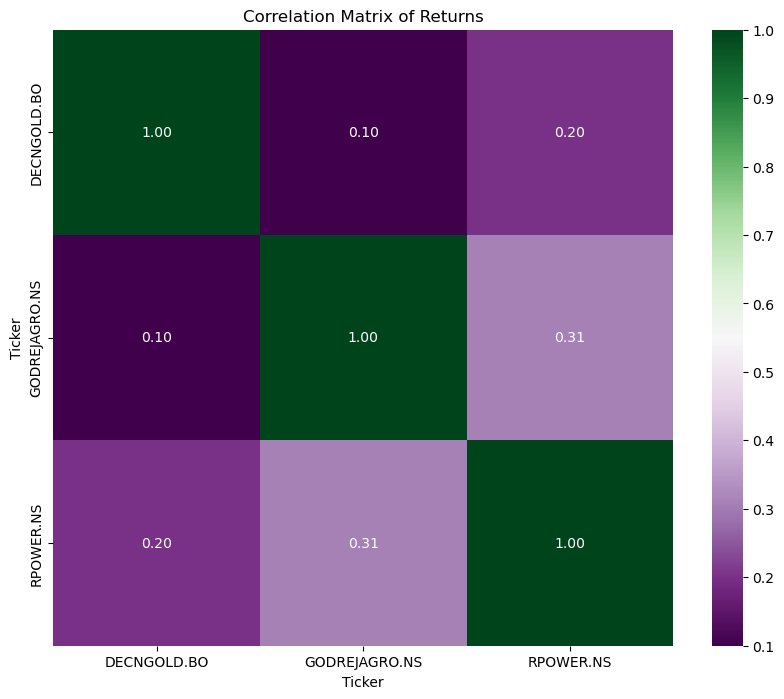

In [18]:
# 3. Create a correlation matrix

correlation_matrix = round(returns.corr(),2)
print("\nCorrelation Matrix:")
print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='PRGn', fmt=".2f")
plt.title("Correlation Matrix of Returns")
plt.show()

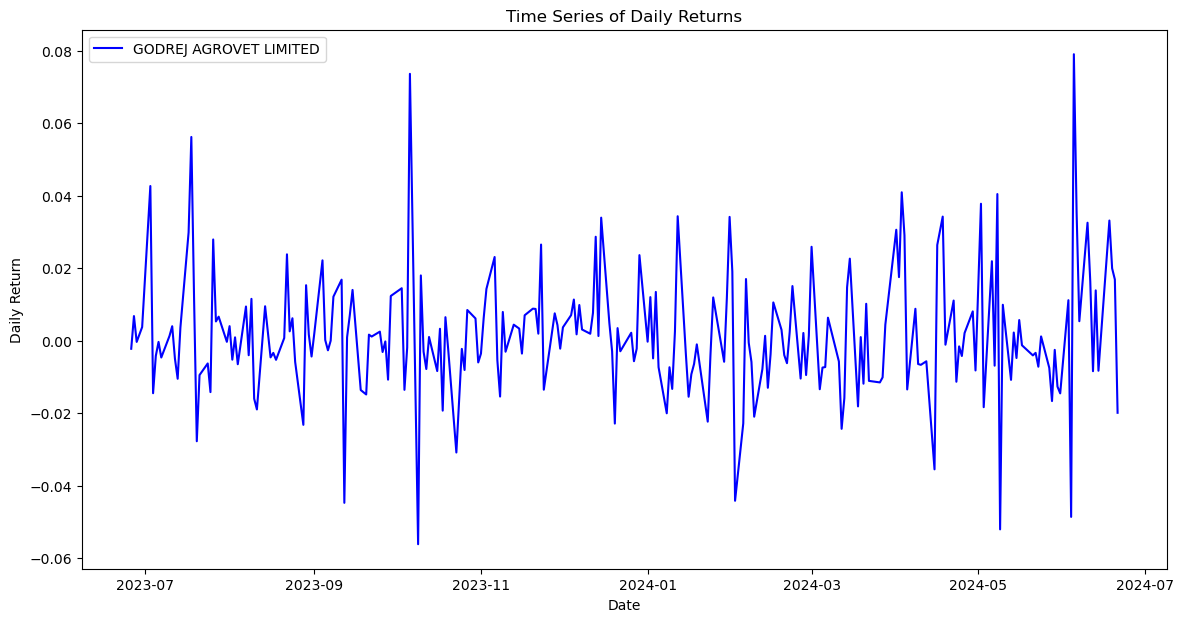

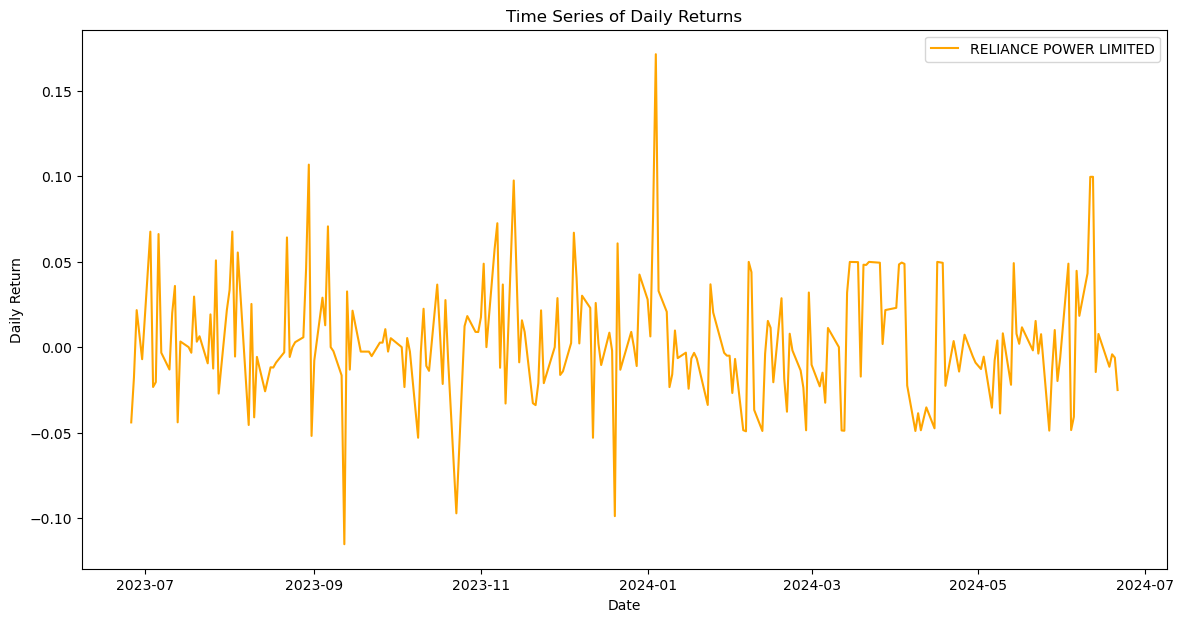

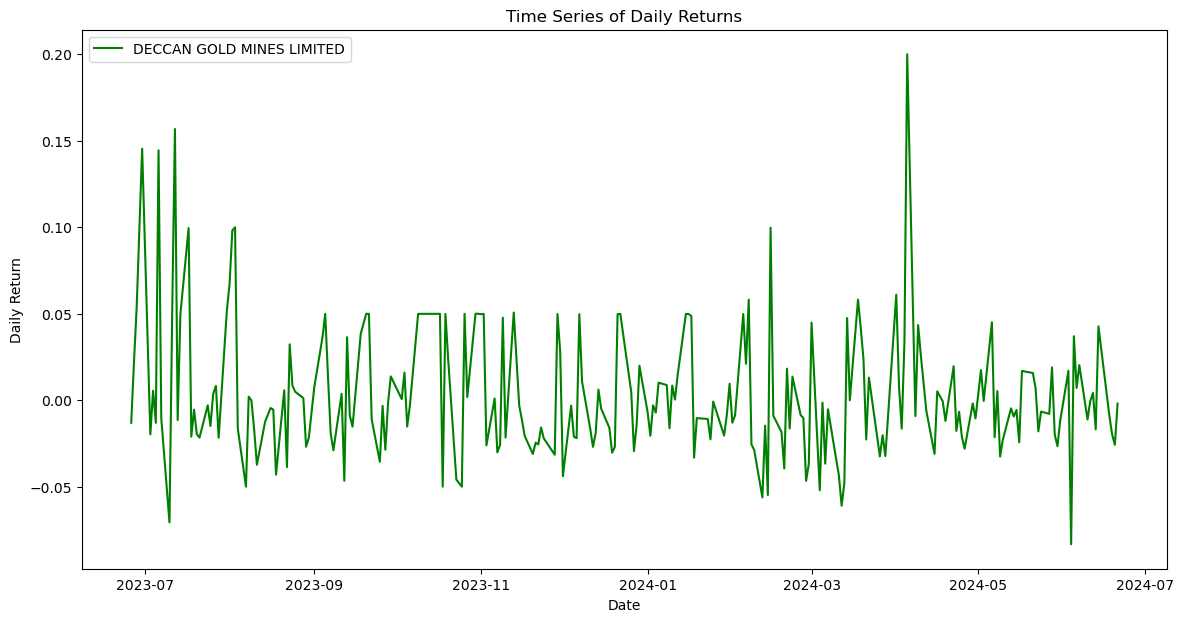

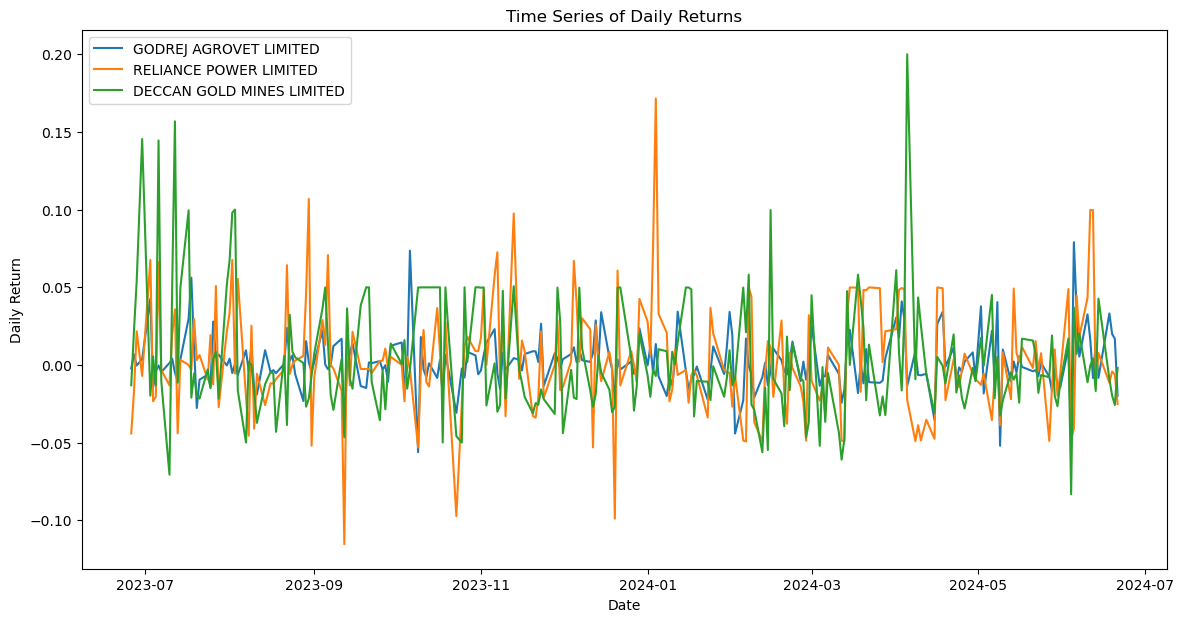

In [19]:
# 4. Plot the time series of returns

colors = ('b','orange','g')
for i, (asset, asset_name) in enumerate(assets.items()):
    plt.figure(figsize=(14, 7))
    plt.plot(returns.index, returns[asset], label=asset_name, color=colors[i % len(colors)])
    plt.title('Time Series of Daily Returns')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.show()

plt.figure(figsize=(14, 7))
for asset, asset_name in assets.items():
    plt.plot(returns.index, returns[asset], label=asset_name)
plt.title('Time Series of Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()


In [20]:
# 5 Check whether the time series is stationary or not

# Function to check stationarity
def check_stationarity(timeseries, asset_name):
    # Perform Augmented Dickey-Fuller test
    result = adfuller(timeseries)
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]
    
    print(f'{asset_name} - Checking Stationary through Results of Augmented Dickey-Fuller Test:')
    print('ADF Statistic:', adf_statistic)
    print('p-value:', p_value)
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key}: {value}')
    
    # Interpret the result
    if adf_statistic < critical_values['5%']:
        print(f"\033[1m\033[4m\033[92mThe time series for {asset_name} is stationary.\n\033[0m")
    else:
        print(f"\033[1m\033[4m\033[91mThe time series for {asset_name} is not stationary.\n\033[0m") 

# Check stationarity for each asset's return series
for asset, asset_name in assets.items():
    check_stationarity(returns[asset], asset_name)

GODREJ AGROVET LIMITED - Checking Stationary through Results of Augmented Dickey-Fuller Test:
ADF Statistic: -16.856183959309828
p-value: 1.1088034494441328e-29
Critical Values:
   1%: -3.4577787098622674
   5%: -2.873608704758507
   10%: -2.573201765981991
The time series for GODREJ AGROVET LIMITED is stationary.

RELIANCE POWER LIMITED - Checking Stationary through Results of Augmented Dickey-Fuller Test:
ADF Statistic: -13.497618424811401
p-value: 3.020252979649595e-25
Critical Values:
   1%: -3.4577787098622674
   5%: -2.873608704758507
   10%: -2.573201765981991
The time series for RELIANCE POWER LIMITED is stationary.

DECCAN GOLD MINES LIMITED - Checking Stationary through Results of Augmented Dickey-Fuller Test:
ADF Statistic: -13.271092165636055
p-value: 8.034692101029479e-25
Critical Values:
   1%: -3.4577787098622674
   5%: -2.873608704758507
   10%: -2.573201765981991
The time series for DECCAN GOLD MINES LIMITED is stationary.



In [21]:
# 6 Fit ARIMA model to each asset's return series

for asset, asset_name in returns.items():
    
    arima_model = ARIMA(returns[asset], order=(1,0,1))
    arima_results = arima_model.fit()
    print(f'\n\n Fitting ARIMA model for {asset_name}')
    print(arima_results.summary())

C:\Users\SANCHIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SANCHIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SANCHIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SANCHIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init



 Fitting ARIMA model for Date
2023-06-26   -0.013032
2023-06-27    0.021663
2023-06-28    0.053918
2023-06-30    0.145430
2023-07-03   -0.019739
                ...   
2024-06-14    0.042694
2024-06-18   -0.009099
2024-06-19   -0.019743
2024-06-20   -0.025761
2024-06-21   -0.001923
Name: DECNGOLD.BO, Length: 242, dtype: float64
                               SARIMAX Results                                
Dep. Variable:            DECNGOLD.BO   No. Observations:                  242
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 449.209
Date:                Sat, 22 Jun 2024   AIC                           -890.419
Time:                        12:48:49   BIC                           -876.463
Sample:                             0   HQIC                          -884.797
                                - 242                                         
Covariance Type:                  opg                                         
                 coef    std err    

C:\Users\SANCHIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SANCHIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SANCHIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)




 Fitting ARIMA model for Date
2023-06-26   -0.044068
2023-06-27   -0.017730
2023-06-28    0.021661
2023-06-30   -0.007067
2023-07-03    0.067616
                ...   
2024-06-14    0.007722
2024-06-18   -0.011494
2024-06-19   -0.004199
2024-06-20   -0.006163
2024-06-21   -0.025131
Name: RPOWER.NS, Length: 242, dtype: float64
                               SARIMAX Results                                
Dep. Variable:              RPOWER.NS   No. Observations:                  242
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 468.829
Date:                Sat, 22 Jun 2024   AIC                           -929.658
Time:                        12:48:50   BIC                           -915.702
Sample:                             0   HQIC                          -924.036
                                - 242                                         
Covariance Type:                  opg                                         
                 coef    std err      

In [24]:
# 7. Use appropriate GARCH model to estimate volatility
# Fit GARCH model to each asset's return series for volatility estimation

for asset, asset_name in returns.items():
    garch_model = arch_model(returns[asset], vol='Garch', p=1, q=1)
    garch_results = garch_model.fit(disp='off')
    
    print(f"GARCH model summary for {asset}:")
    print(garch_results.summary())
    print()

C:\Users\SANCHIT\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001464. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\SANCHIT\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003015. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\SANCHIT\anaconda3\Lib\site-packages\arch\univariate\base.py:311: 

GARCH model summary for DECNGOLD.BO:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            DECNGOLD.BO   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                460.241
Distribution:                  Normal   AIC:                          -912.482
Method:            Maximum Likelihood   BIC:                          -898.526
                                        No. Observations:                  242
Date:                Sat, Jun 22 2024   Df Residuals:                      241
Time:                        12:49:23   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -2.1

C:\Users\SANCHIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SANCHIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SANCHIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SANCHIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_ind



Forecasted Prices:
            GODREJAGRO.NS  RPOWER.NS  DECNGOLD.BO
2024-06-24     618.410626  29.845053   104.044950
2024-06-25     619.433961  29.884156   104.399006
2024-06-26     620.389249  29.955227   104.783609
2024-06-27     621.340856  30.042394   105.177564
2024-06-28     622.293542  30.137767   105.575146
2024-07-01     623.247661  30.237414   105.974812
2024-07-02     624.203240  30.339374   106.376147
2024-07-03     625.160284  30.442669   106.779045
2024-07-04     626.118796  30.546810   107.183480
2024-07-05     627.078777  30.651554   107.589451
2024-07-08     628.040230  30.756782   107.996960
2024-07-09     629.003157  30.862432   108.406012
2024-07-10     629.967561  30.968476   108.816614
2024-07-11     630.933443  31.074900   109.228771
2024-07-12     631.900806  31.181697   109.642489
2024-07-15     632.869652  31.288865   110.057775
2024-07-16     633.839984  31.396403   110.474633
2024-07-17     634.811804  31.504312   110.893070
2024-07-18     635.785113  31

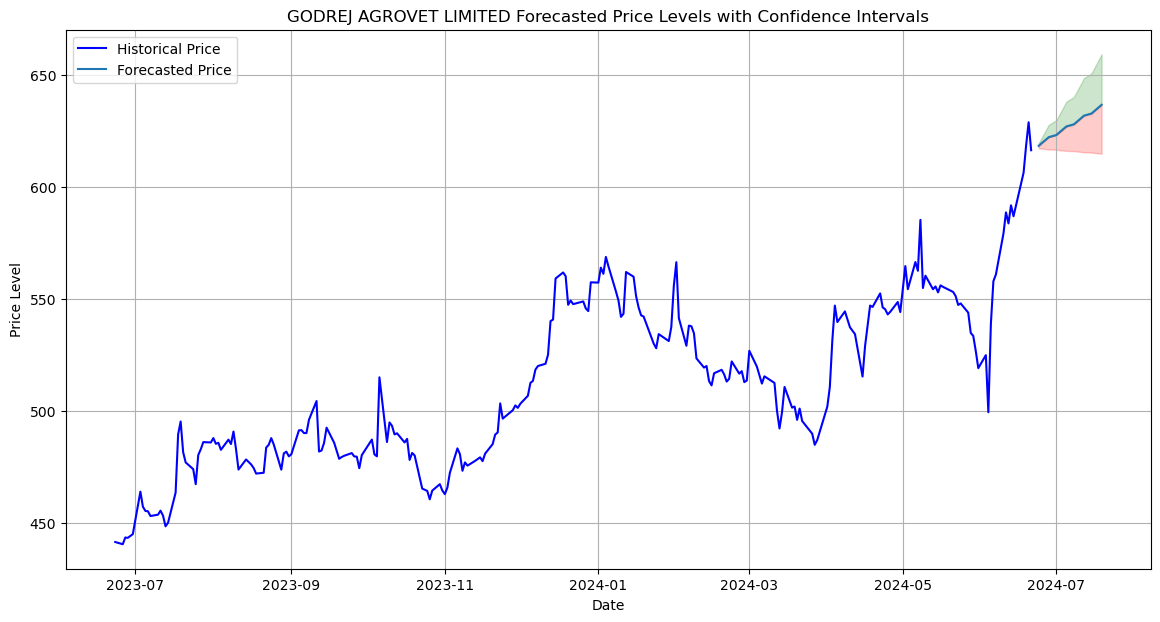

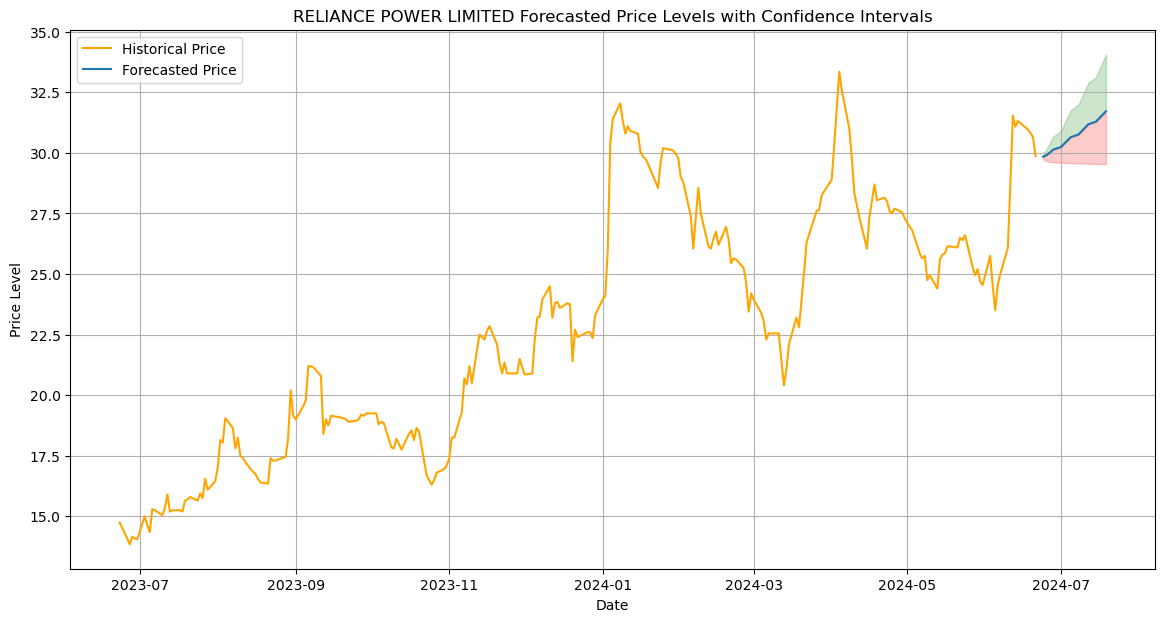

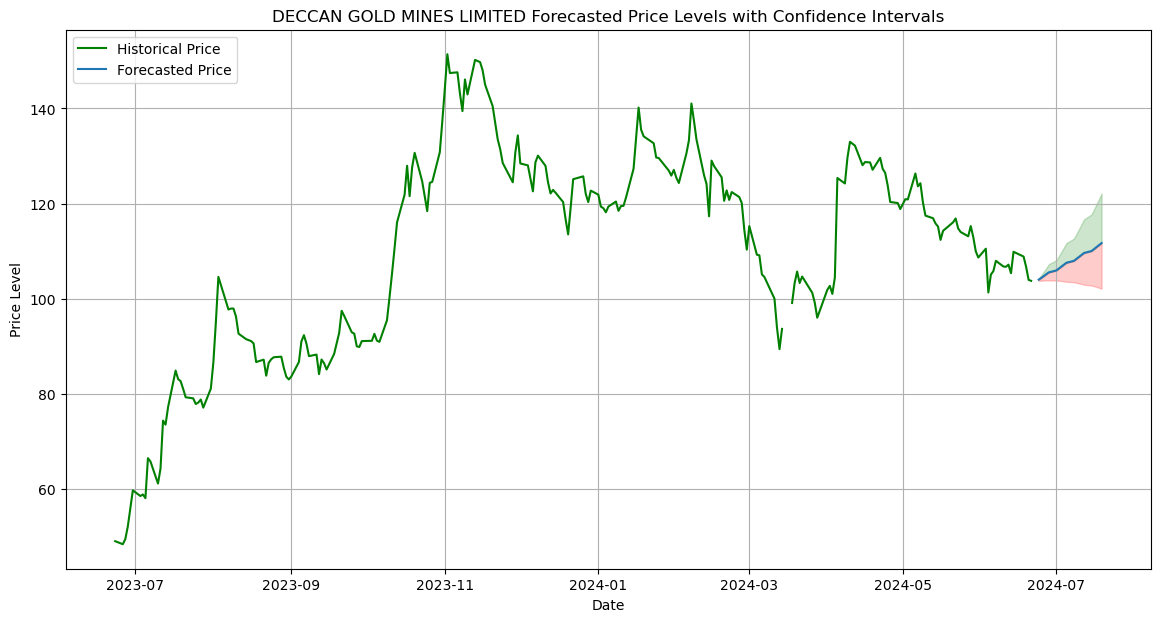

In [25]:
# 8. Forecast the values for next 20 days
# Forecast horizon
forecast_horizon = 20

# DataFrame to store forecasted price levels and confidence intervals
forecast_prices = pd.DataFrame(index=pd.date_range(start=returns.index[-1] + timedelta(days=1), periods=forecast_horizon, freq='B'))
upper_confidence = pd.DataFrame(index=forecast_prices.index)
lower_confidence = pd.DataFrame(index=forecast_prices.index)

# Dictionary to store forecasted volatilities
forecast_volatility = {}

for asset, asset_name in assets.items():
    # Fit ARIMA model
    arima_model = ARIMA(returns[asset], order=(1, 0, 1))
    arima_results = arima_model.fit()
    
    # Forecast returns
    forecasted_returns = arima_results.forecast(steps=forecast_horizon)
    
    # Convert forecasted returns to price levels
    last_price = adj_close_data[asset].iloc[-1]
    forecasted_prices_asset = last_price * (1 + forecasted_returns).cumprod()
    forecast_prices[asset] = forecasted_prices_asset.values  # Store the forecasted prices in the DataFrame
    
    # Fit GARCH model
    garch_model = arch_model(returns[asset], vol='Garch', p=1, q=1)
    garch_results = garch_model.fit(disp='off')
    
    # Forecast volatility (GARCH)
    forecast_vol = garch_results.forecast(horizon=forecast_horizon)
    forecast_volatility[asset] = forecast_vol.variance.values
    #forecast_volatility[asset] = forecast_vol.mean.iloc[-1]
    

    # Calculate confidence intervals based on forecasted volatility
    forecasted_std_dev = np.sqrt(forecast_vol.variance.values[-1]/100)
    upper_confidence[asset] = forecasted_prices_asset.values * (1 + forecasted_std_dev).cumprod()
    lower_confidence[asset] = forecasted_prices_asset.values * (1 - forecasted_std_dev).cumprod()

print(f'\n\n\033[1m\033[4m\033[93mForecasted Prices:\33[0m')
print(forecast_prices)
print('\n\n\033[1m\033[4m\033[93mVolatility:\33[0m')
print(forecast_volatility)
print(f'\n\n\033[1m\033[4m\033[92mUpper Confidence:\33[0m')
print(upper_confidence)
print('\n\n\033[1m\033[4m\033[91mLower Confidence:\33[0m')
print(lower_confidence)


# Plotting the forecasted price levels and confidence intervals

colors = ('b','orange','g')
for i, (asset, asset_name) in enumerate(assets.items()):
    plt.figure(figsize=(14, 7))
    plt.plot(adj_close_data[asset], label='Historical Price', color=colors[i % len(colors)])
    plt.plot(forecast_prices.index, forecast_prices[asset], label='Forecasted Price')
    plt.fill_between(forecast_prices.index, forecast_prices[asset], upper_confidence[asset], color='green', alpha=0.2)
    plt.fill_between(forecast_prices.index, lower_confidence[asset], forecast_prices[asset], color='red', alpha=0.2)
    plt.title(f'{asset_name} Forecasted Price Levels with Confidence Intervals')
    plt.xlabel('Date')
    plt.ylabel('Price Level')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()
